<a href="https://colab.research.google.com/github/sofiasilvosa/Investigating-Plastic-Pollution-in-the-United-States/blob/main/step_1_memory_preprocessing_CNRI_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing Script for Online Memory Task

Overall, this script takes output from a Duke web server (the one that hosts the Step 2 Memory task for the study), which is organized as a json object and converts that json object into a pandas dataframe and eventually a csv.

The json file has four columns, the first is a unique server code given for a specific run of the task, the second column is the number screen they're on, the third column is some sort of timing data, and then the fourth column has all of the data inside it (in dictionary form, "key": "value" pairings).


**Variable Names in fourth column:**
- subjectId: subject ID number (given to by experimenter)
- version: version of the study (should always say "CUR-Memory")
- trialNumber: trial number
- trialAnswer: the name of the video being played on this trial
- finalAnswer: name of video participant reported once video finished
- midVideoAnswer: name of video participant reported during video play
- finalGuess: time when subj indicates they remember the video during video play
- oldNewValue: old new judgement scale (scale: 1, definitely old - 4, definitely new) 
- runValue: reported run a video came from if new 
    - 1: maybe run one
    - 2: definitely run one
    - 3: maybe run two 
    - 4: definitely run two
    - 5: maybe run three
    - 6: definitely run three
    - 7: new video
- recallList: list of videos reported in recall 

### TO DO:

For this script, the goal is to examine and try to understand how data is being processed through the commands below. For some of the things, you will need to fill in the code, I've provided some hints along the way!

## import libraries

The first thing we need to do is specify what libraries we will need to look at and edit the data. While base python is powerful, these libraries make data processing MUCH EASIER! I've labeled what some of the libraries below there main functions for this script.

In [ ]:
import os
import pandas as pd # library for all things dataframes! Useful for organizing data and setting up analyses
import numpy as np # library for all things numbers
import json # library to help us transform json objects into pandas dataframes
import matplotlib.pyplot as plt # library for making plots/data visualizations
import seaborn as sns # library for making plots pretty
import math # library for using more specific math functions/operations
from scipy.stats import zscore 

import warnings # just helps ignore warnings that we don't care about (see below call)
%matplotlib inline 

warnings.filterwarnings('ignore')

## load data files

First, we need to load in our datafile so we can start working with it. To read in a datafile, google `pandas read csv`. 

In [ ]:
data = pd.read_csv('/trialdata_20220225.csv')
data.head() # display the first 5 rows of the dataframe

,name,trial,time,data
0,debug3cGOU:debug6m86c,0,1.625320e+12,"{""phase"": ""INSTRUCTIONS"", ""templates"": [""instr..."
1,debug3cGOU:debug6m86c,1,1.625320e+12,"{""phase"": ""INSTRUCTIONS"", ""indexOf"": 0, ""viewT..."
2,debug3e0a5:debug45uB3,0,1.644100e+12,"{""phase"": ""INSTRUCTIONS"", ""templates"": [""instr..."
3,debug3e0a5:debug45uB3,1,1.644100e+12,"{""phase"": ""INSTRUCTIONS"", ""indexOf"": 0, ""viewT..."
4,debug3e0a5:debug45uB3,2,1.644100e+12,"{""finalGuess"": 13.956211111111111, ""trialAnswe..."


### take note of participant server ID's

So, within this dataframe, there is our real participant data plus any pilot data, incomplete data, etc. We need to first filter to include only the participant who are real. Don't worry about finding our real participants, they've been specified below.  

In [ ]:
real_participants = ['debugeAi00:debugfvC2I', 'debugEGe65:debugVjXxD', 'debugkVYZC:debugx9fcJ', 'debug3e0a5:debug45uB3',
                     'debugI35hd:debugSOTca', 'debuglhp3K:debugJ8e1d', 'debugMyFhF:debugzR9RH', 'debugpgWzE:debugJvKMh', 
                     'debugv3YQA:debug2BcFR', 'debugYDHLp:debugYr1jm']

In [ ]:
# remove instruction instances/screens from rows of data
data = data[~data.data.str.contains('phase')].reset_index()

# remove old versions of task
data = data[data.data.str.contains('recallList')].reset_index()

# remove pilot subjs and other tests of task
data = data[data.name.isin(real_participants)]

# check to see everyone has the right number of trials
data.groupby('name').count() # everyone should have 55 trials completed

,level_0,index,trial,time,data
name,,,,,
debug3e0a5:debug45uB3,55,55,55,55,55
debugEGe65:debugVjXxD,55,55,55,55,55
debugI35hd:debugSOTca,55,55,55,55,55
debugMyFhF:debugzR9RH,55,55,55,55,55
debugYDHLp:debugYr1jm,55,55,55,55,55
debugeAi00:debugfvC2I,55,55,55,55,55
debugkVYZC:debugx9fcJ,55,55,55,55,55
debuglhp3K:debugJ8e1d,55,55,55,55,55
debugpgWzE:debugJvKMh,55,55,55,55,55


## rework data into pandas dataframe form

This is a big chunk of code. You don't need to worry about the details here but basically, what this block of code is doing is taking the fourth column of the csv file you are reading in and parsing that out to separate and reorganize the data into columns instead of key:value pairs. 

The way that the data will now be organized is each column represents a variable of interest and each row represents a single trial that a participant completed. So, each participant should still have 55 rows. 

In [ ]:
by_subj = data.groupby('name')

partial_data = []
exclude_list = []
expanded_lst = []

for key, group in by_subj:
    if key in exclude_list:
        pass
    elif group.shape[0] < 55:
        partial_data.append(key)
    else:
        
        columns = ['key', 'subj', 'version', 'trial_number', 'trial_video', 'mid_video_answer', 'mid_video_time', 'final_answer', 'old_new_judge', 'run_judge', 'recall_list']  

        tmp = pd.DataFrame(columns=columns)

        subj_id = list()
        version = list()
        trial_number = list()
        mid_video_answer = list()
        trial_video = list()
        final_answer = list()
        mid_video_time = list()
        old_new_judge = list()
        run_judge = list()
        recall_list = list()

        for item in group['data']:
            a = json.loads(item)

            subj_id.append(a['subjectId'].strip().lower()) 
            version.append(a['version'])
            trial_number.append(int(a['trialNumber']))
            trial_video.append(a['trialAnswer'])
            mid_video_answer.append(a['midVideoAnswer'])
            mid_video_time.append(float(a['finalGuess']))
            final_answer.append(a['finalAnswer'])
            old_new_judge.append(int(a['oldNewValue']))
            run_judge.append(int(a['runValue']))
            recall_list.append(a['recallList'])

        tmp.key = [key] * len(subj_id)
        tmp.subj = subj_id
        tmp.version = version
        tmp.trial_number = trial_number
        tmp.trial_video = trial_video
        tmp.mid_video_answer = mid_video_answer
        tmp.mid_video_time = mid_video_time
        tmp.final_answer = final_answer
        tmp.old_new_judge = old_new_judge
        tmp.run_judge = run_judge
        tmp.recall_list = recall_list

        expanded_lst.append(tmp)

data_expand = pd.concat(expanded_lst)

In [ ]:
data_expand.head(20) 
# now, you should see that the data looks a lot more spread out and each variable has its own 
# column with all the data falling beneath each column

,key,subj,version,trial_number,trial_video,mid_video_answer,mid_video_time,final_answer,old_new_judge,run_judge,recall_list
0,debug3e0a5:debug45uB3,17,CUR-Memory,0,zebra_new,zebra,13.956211,Zebra,3,7,"[elephant, tiger, harp, flower, pineapple, tac..."
1,debug3e0a5:debug45uB3,17,CUR-Memory,1,pencil_20s,laptop,6.150322,Pencil,1,3,"[elephant, tiger, harp, flower, pineapple, tac..."
2,debug3e0a5:debug45uB3,17,CUR-Memory,2,car_20s,Car,3.804100,Car,1,4,"[elephant, tiger, harp, flower, pineapple, tac..."
3,debug3e0a5:debug45uB3,17,CUR-Memory,3,scribble_18,Scribble,11.637267,Scribble,1,1,"[elephant, tiger, harp, flower, pineapple, tac..."
4,debug3e0a5:debug45uB3,17,CUR-Memory,4,scribble_27,,0.000000,scribble,3,7,"[elephant, tiger, harp, flower, pineapple, tac..."
5,debug3e0a5:debug45uB3,17,CUR-Memory,5,scribble5_new,,0.000000,scribble,3,7,"[elephant, tiger, harp, flower, pineapple, tac..."
6,debug3e0a5:debug45uB3,17,CUR-Memory,6,scribble3_new,,0.000000,scribble,2,1,"[elephant, tiger, harp, flower, pineapple, tac..."
7,debug3e0a5:debug45uB3,17,CUR-Memory,7,scribble_19,scribble,8.701600,scribble,1,5,"[elephant, tiger, harp, flower, pineapple, tac..."
8,debug3e0a5:debug45uB3,17,CUR-Memory,8,hand_20s,Hand,16.282321,Hand,1,4,"[elephant, tiger, harp, flower, pineapple, tac..."
9,debug3e0a5:debug45uB3,17,CUR-Memory,9,bull_20s,Bull,12.217311,Bull,1,2,"[elephant, tiger, harp, flower, pineapple, tac..."


## add additional columns

So, here we want you to try to add a column to the data frame. Adding a columns looks a little like this: 

`data['name of new column'] = 'process that gives you the information you want for said new columns'`

For the two columns to create, using `strings` will be your friend here! To compare strings across cells, I'd recommend these two functions:

- `np.where()`: a function which can help identity specific cells in a column (conditionality)
- `.str.contains('WORD')`: a method which can help match partial strings

Remember the difference between methods and functions and I encourage you to google these code snippets

In [ ]:
# example 1
data_expand['run_number_guess'] = np.where(data_expand.run_judge < 3, 1, 
                   np.where((data_expand.run_judge < 5) & (data_expand.run_judge > 2), 2,
                   pd.np.where((data_expand.run_judge < 7) & (data_expand.run_judge > 4), 3, 4)))

In [ ]:
# example 2
data_expand['run_confidence'] = pd.np.where(data_expand.run_judge == 7, 'new', 
                   pd.np.where((data_expand.run_judge == 1) | (data_expand.run_judge == 3) | (data_expand.run_judge == 5), 'low', 'high'))

In [ ]:
# create a column that identifies if a video on a trial is NEW or OLD
data_expand['old_new'] = np.where(data_expand.trial_video.str.contains('new'), 'new', 'old')

In [ ]:
# create a column that identifies if a video is a scribble or a real video
data_expand['real_scribble'] = pd.np.where(data_expand.trial_video.str.contains('scribble'), 'scribble', 'real')

### recall list

So for here, right now we're just taking the number of recalled videos that people reported before starting phase 2 of the memory task. We will examing the actual contents of the recall at a later date. 

In [ ]:
# add recall list counts
recall_count = [] 

for key, group in data_expand.groupby('subj'):
    recall = len(group.recall_list.values[0])
    temp = pd.DataFrame([[key, recall]], columns=['subj', 'recall_count'])
    recall_count.append(temp)

recall_df = pd.concat(recall_count)

In [ ]:
recall_df

,subj,recall_count
0,10,7
0,14,5
0,16,5
0,17,7
0,28,4
0,3,5
0,4,12
0,6,18
0,8,3
0,8684,5


In [ ]:
data_expand = data_expand.merge(recall_df, on=['subj'], how='left')

## dataframe descriptives

Now, our data is mostly preprocessed. Below are some introductions to data descriptives and plotting functions that help us visualize the data. Run through the below code and take note of things that surprised you or things that matched your intuitions. 

In [ ]:
data_expand.subj.nunique() # method for identifying the number of unique instances in a given column

10

In [ ]:
data_expand.shape[0] # method for identifying the number of unique instances in a given column

550

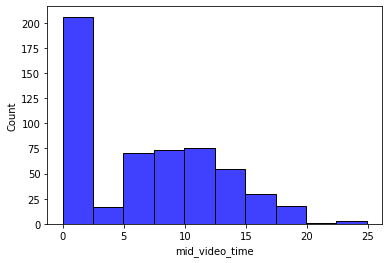

In [ ]:
# first let's look at the distribution of memory responses (when people selected that they "remembered the video")
# to do so, let's make a histogram. Google `seaborn histplot` 
sns.histplot(data_expand.mid_video_time, bins= 10, color= "blue") 

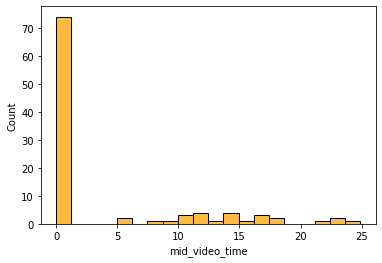

In [ ]:
# well, we know that all of our trials include new videos as well as old videos. 
# Let's see if we can create a histogram looking only at videos participants saw in session 1
sns.histplot(data_expand[data_expand.old_new == 'new'].mid_video_time, bins=20, color='orange')

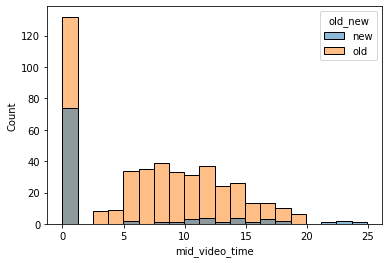

In [ ]:
sns.histplot(data= data_expand, x = 'mid_video_time', hue= "old_new", bins= 20)

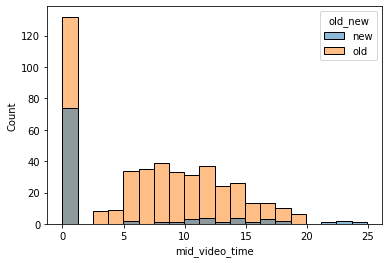

In [ ]:
sns.histplot(data=data_expand, x='mid_video_time', hue='old_new', bins=20)

In [ ]:
# you can check here how often a remembered video did not elicit a mid-video "I remember the video" response
print(data_expand[(data_expand.old_new == 'old') & (data_expand.mid_video_time > 0)].shape[0])
print(data_expand[(data_expand.old_new == 'old') & (data_expand.mid_video_time == 0)].shape[0])

318
132


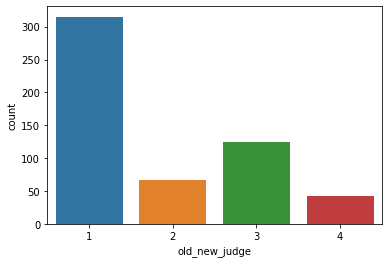

In [ ]:
# let's examine how people were using the old-new scale
sns.countplot(data_expand.old_new_judge)

In [ ]:
g= sns.FacetGrid(data_expand, col= "real_scribble")
g.map(sns.countplot, "old_new_judge")

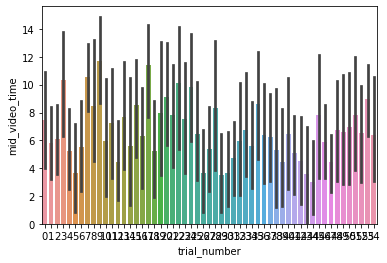

In [ ]:
sns.barplot(x= "trial_number", y= "mid_video_time", data= data_expand)

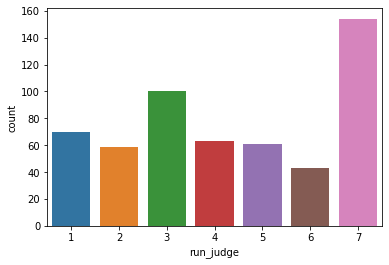

In [ ]:
# we can use the same countplot function to look at people's memory for what run they saw the video in from session 1
sns.countplot(data_expand.run_judge)

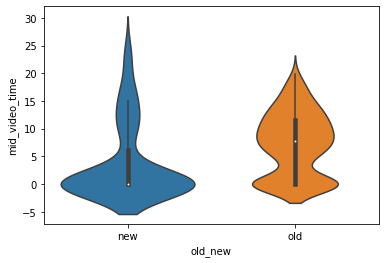

In [ ]:
sns.violinplot(x= "old_new", y= "mid_video_time", data= data_expand)

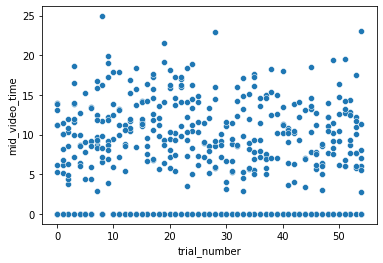

In [ ]:
sns.scatterplot(x= "trial_number", y = "mid_video_time", data= data_expand)

In [ ]:
data_expand




,key,subj,version,trial_number,trial_video,mid_video_answer,mid_video_time,final_answer,old_new_judge,run_judge,recall_list,run_number_guess,run_confidence,old_new,real_scribble,recall_count
0,debug3e0a5:debug45uB3,17,CUR-Memory,0,zebra_new,zebra,13.956211,Zebra,3,7,"[elephant, tiger, harp, flower, pineapple, tac...",4,new,new,real,7
1,debug3e0a5:debug45uB3,17,CUR-Memory,1,pencil_20s,laptop,6.150322,Pencil,1,3,"[elephant, tiger, harp, flower, pineapple, tac...",2,low,old,real,7
2,debug3e0a5:debug45uB3,17,CUR-Memory,2,car_20s,Car,3.804100,Car,1,4,"[elephant, tiger, harp, flower, pineapple, tac...",2,high,old,real,7
3,debug3e0a5:debug45uB3,17,CUR-Memory,3,scribble_18,Scribble,11.637267,Scribble,1,1,"[elephant, tiger, harp, flower, pineapple, tac...",1,low,old,scribble,7
4,debug3e0a5:debug45uB3,17,CUR-Memory,4,scribble_27,,0.000000,scribble,3,7,"[elephant, tiger, harp, flower, pineapple, tac...",4,new,old,scribble,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,debugv3YQA:debug2BcFR,28,CUR-Memory,50,scribble_17,,0.000000,Not sure what this is,3,7,"[Elephant, Tiger, Pencil, Laptop]",4,new,old,scribble,4
546,debugv3YQA:debug2BcFR,28,CUR-Memory,51,scribble_26,,0.000000,Not sure what this is,2,1,"[Elephant, Tiger, Pencil, Laptop]",1,low,old,scribble,4
547,debugv3YQA:debug2BcFR,28,CUR-Memory,52,bull_20s,Horse,12.517250,Bull,2,3,"[Elephant, Tiger, Pencil, Laptop]",2,low,old,real,4
548,debugv3YQA:debug2BcFR,28,CUR-Memory,53,corn_new,Corn,11.708625,Corn,3,7,"[Elephant, Tiger, Pencil, Laptop]",4,new,new,real,4


### use the space below to make some of your own plots! 

To get started, here are some things to think about...

1. Is recognition memory (old/new) better for scribble vs. real videos?
2. Is source memory (memory for run number) better for scribble vs. real videos?
3. Does confidence scale with accuracy? In other words, when people say they're confident, are they actually more accurate?

## output csv

We will save our processed data to later link to the behavioral data from session 1.

In [ ]:
data_expand.to_csv('memory_processed_20220203.csv')

## Make and save recall dataframe

### First, we are going to isolate just the recall responses for each person

Think about the structure of the data for this. You know that each person's recall data is stored in the column `recall_list` and is repeated for every row of data that person has. We only need once instance (or one row) of that data, so we can get rid of all of the other rows except for one per person. 

In [ ]:
# to isolate just one row for each person, google the pandas function "drop duplicates".
# create a new dataframe from your data_expand dataframe that just has one row per person below
recall_list= data_expand.drop_duplicates( subset= ['subj'], keep= 'first') [["subj", "recall_list"]]

recall_list


,subj,recall_list
0,17,"[elephant, tiger, harp, flower, pineapple, tac..."
55,8684,"[Guitar, Tree, Banana, Elephant, Controller]"
110,4,"[Guitar, Tiger, Bull, Pineapple, palm tree, sa..."
165,3,"[harp, flower, violin, palm tree, leaves]"
220,8,"[pineapple, dinosaur, banana]"
275,10,"[Harper, Flute, Guitar, Car, Tiger, Ballerina,..."
330,6,"[car, latte art, tiger, surfing, violin, bear,..."
385,14,"[tiger, car, skateboard, elephant, taco]"
440,16,"[car, headphones, tiger, hand, shoe]"
495,28,"[Elephant, Tiger, Pencil, Laptop]"


In [ ]:
# this is still way too much information for us since we're only interested in recall.
# let's remove all of the columns we're not interested in for now, just keeping the subject number and the recall list
# Hint: https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html

#recall_sub =  new[["subj", "recall_list"]]
#data_expand.explode("recall_list")
recall_list = recall_list.explode('recall_list')


In [ ]:
# check to make sure your new dataframe has the data you want in it
recall_list.head(20)

,subj,recall_list
0,17,elephant
0,17,tiger
0,17,harp
0,17,flower
0,17,pineapple
0,17,taco
0,17,laptop
55,8684,Guitar
55,8684,Tree
55,8684,Banana


### Next we're going to expand our lists so that each video name has it's own row

We'd like to get this data into a more usable form, so for that, we want each to end up with a dataframe where each row contains the particiapnt number and a single word from the recall list. That means each participant will have as many rows as they have recalled videos. 

In [ ]:
recall_list['order'] = recall_list.groupby('subj').cumcount()+1

recall_list
# need + 1 because python starts counting at 0
recall_list.head(20)

,subj,recall_list,order
0,17,elephant,1
0,17,tiger,2
0,17,harp,3
0,17,flower,4
0,17,pineapple,5
0,17,taco,6
0,17,laptop,7
55,8684,Guitar,1
55,8684,Tree,2
55,8684,Banana,3


In [ ]:
# first, we need to find a way to expand our list. Pandas has a really easy to use function 
# for this but here is a good opportunity to practice your googling skills. I'm not going to give you the name of the function.
# Instead, google what you know about how the problem is set up and what you want your output to look like. 
# expand the lists for each person in below. 

for i in range(len(recall_list)):
    pd.recall_sub[recall_list] = recall_list[i]





KeyError: ignored

In [ ]:
# Lastly, we also want to maintain the order that the words were entered (maintain the index information from the list), and we want to store 
# this information in another column. So, essentially, you'll end up with a three-column dataframe that has "subj", "recall_list", and "order"
# as your columns. For order, you'd expect the rows to look like:

# subj  recall_list  order
# 10    boat         1
# 10    elephant     2
# 10    dancer       3
# 10    dog          4
# 8     elephant     1
# 8     tiger        2
# ....

# so for each word, there's a number associated with them that resets when we move from subject to subject. 
# so, you need to find a way to group data by participant (HINT: groupby) and count the cells (HINT: cumcount()+1 (because Python starts at zero))
# Add your order column below


In [ ]:
# check to make sure your dataframe looks as you'd expect!


In [ ]:
# save your dataframe to a csv file (Google, pandas .to_csv)
recall_list.to_csv('recall_preprocessed.csv')


NameError: ignored